In [1]:
import math
import os
import time
from statistics import mean

import matplotlib.pyplot as plt
import mlflow
import torch
from torch.cuda.amp import autocast
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.mask_rcnn import MaskRCNN
from tqdm.auto import tqdm as tq

from craterdetection.detection.training import CraterInstanceDataset, collate_fn
from craterdetection.detection.visualisation import draw_patches

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
mlflow.set_tracking_uri("http://localhost:5000/")
mlflow.set_experiment("crater-detection")

In [3]:
dataset_path = "../data/dataset_instanced_edge.h5"
train_dataset = CraterInstanceDataset(file_path=dataset_path, group="training")
train_loader = DataLoader(train_dataset, batch_size=10, num_workers=2, collate_fn=collate_fn, shuffle=True)

validation_dataset = CraterInstanceDataset(file_path=dataset_path, group="validation")
validation_loader = DataLoader(validation_dataset, batch_size=10, num_workers=0, collate_fn=collate_fn)

test_dataset = CraterInstanceDataset(file_path=dataset_path, group="test")
test_loader = DataLoader(test_dataset, batch_size=4, num_workers=0, collate_fn=collate_fn, shuffle=True)

In [4]:
NUM_CLASSES = 2

backbone = resnet_fpn_backbone('resnet50', pretrained=True, trainable_layers=5)

model = MaskRCNN(
    backbone=backbone,
    num_classes=NUM_CLASSES,
    min_size=256,
    max_size=256
)

In [5]:
pretrained = True
checkpoint_path = "../blobs/CraterRCNN_0bb45f4d98d9409d9bf4bdfe7d2b4436.pth"
initial_lr = 1e-3

if pretrained:
    checkpoint = torch.load(checkpoint_path)

    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = SGD(params, lr=initial_lr, momentum=0.5, weight_decay=1e-7)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
else:
    checkpoint = dict()
    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = SGD(params, lr=initial_lr, momentum=0.5, weight_decay=1e-7)

scheduler = StepLR(optimizer, step_size=10)

0bb45f4d98d9409d9bf4bdfe7d2b4436

-----Epoch 13 started-----



Training [13]:   0%|          | 0/1000 [00:00<?, ?it/s, loss_box_reg=0, loss_classifier=0, loss_mask=0, loss_o…

Validation [13]:   0%|          | 0/100 [00:00<?, ?it/s, loss_box_reg=0, loss_classifier=0, loss_mask=0, loss_…


Summary:
 	Epoch: 13/30
 	Average train loss: 1.9825242499113083
 	Average validation loss: 1.7656531369686126
 	Duration: 6m 9s
-----Epoch 13 finished.-----


-----Epoch 14 started-----



Training [14]:   0%|          | 0/1000 [00:00<?, ?it/s, loss_box_reg=0, loss_classifier=0, loss_mask=0, loss_o…

Validation [14]:   0%|          | 0/100 [00:00<?, ?it/s, loss_box_reg=0, loss_classifier=0, loss_mask=0, loss_…


Summary:
 	Epoch: 14/30
 	Average train loss: 2.012330405116081
 	Average validation loss: 1.8554549658298491
 	Duration: 6m 9s
-----Epoch 14 finished.-----


-----Epoch 15 started-----



Training [15]:   0%|          | 0/1000 [00:00<?, ?it/s, loss_box_reg=0, loss_classifier=0, loss_mask=0, loss_o…

Validation [15]:   0%|          | 0/100 [00:00<?, ?it/s, loss_box_reg=0, loss_classifier=0, loss_mask=0, loss_…


Summary:
 	Epoch: 15/30
 	Average train loss: 1.9576640592813492
 	Average validation loss: 1.725478346347809
 	Duration: 6m 8s
-----Epoch 15 finished.-----


-----Epoch 16 started-----



Training [16]:   0%|          | 0/1000 [00:00<?, ?it/s, loss_box_reg=0, loss_classifier=0, loss_mask=0, loss_o…

Validation [16]:   0%|          | 0/100 [00:00<?, ?it/s, loss_box_reg=0, loss_classifier=0, loss_mask=0, loss_…


Summary:
 	Epoch: 16/30
 	Average train loss: 1.8932199226617814
 	Average validation loss: 1.70836057305336
 	Duration: 6m 11s
-----Epoch 16 finished.-----


-----Epoch 17 started-----



Training [17]:   0%|          | 0/1000 [00:00<?, ?it/s, loss_box_reg=0, loss_classifier=0, loss_mask=0, loss_o…

Validation [17]:   0%|          | 0/100 [00:00<?, ?it/s, loss_box_reg=0, loss_classifier=0, loss_mask=0, loss_…


Summary:
 	Epoch: 17/30
 	Average train loss: 1.947405909061432
 	Average validation loss: 2.1802657043933866
 	Duration: 6m 15s
-----Epoch 17 finished.-----


-----Epoch 18 started-----



Training [18]:   0%|          | 0/1000 [00:00<?, ?it/s, loss_box_reg=0, loss_classifier=0, loss_mask=0, loss_o…

Validation [18]:   0%|          | 0/100 [00:00<?, ?it/s, loss_box_reg=0, loss_classifier=0, loss_mask=0, loss_…


Summary:
 	Epoch: 18/30
 	Average train loss: 1.9452443822622298
 	Average validation loss: 1.7379077470302582
 	Duration: 6m 9s
-----Epoch 18 finished.-----


-----Epoch 19 started-----



Training [19]:   0%|          | 0/1000 [00:00<?, ?it/s, loss_box_reg=0, loss_classifier=0, loss_mask=0, loss_o…

Validation [19]:   0%|          | 0/100 [00:00<?, ?it/s, loss_box_reg=0, loss_classifier=0, loss_mask=0, loss_…


Summary:
 	Epoch: 19/30
 	Average train loss: 1.9754008146524429
 	Average validation loss: 1.7119896936416625
 	Duration: 6m 14s
-----Epoch 19 finished.-----


-----Epoch 20 started-----



Training [20]:   0%|          | 0/1000 [00:00<?, ?it/s, loss_box_reg=0, loss_classifier=0, loss_mask=0, loss_o…

Validation [20]:   0%|          | 0/100 [00:00<?, ?it/s, loss_box_reg=0, loss_classifier=0, loss_mask=0, loss_…


Summary:
 	Epoch: 20/30
 	Average train loss: 1.9637885483503341
 	Average validation loss: 1.8263372945785523
 	Duration: 6m 17s
-----Epoch 20 finished.-----


-----Epoch 21 started-----



Training [21]:   0%|          | 0/1000 [00:00<?, ?it/s, loss_box_reg=0, loss_classifier=0, loss_mask=0, loss_o…

Validation [21]:   0%|          | 0/100 [00:00<?, ?it/s, loss_box_reg=0, loss_classifier=0, loss_mask=0, loss_…


Summary:
 	Epoch: 21/30
 	Average train loss: 2.003894440174103
 	Average validation loss: 2.605397653579712
 	Duration: 6m 17s
-----Epoch 21 finished.-----


-----Epoch 22 started-----



Training [22]:   0%|          | 0/1000 [00:00<?, ?it/s, loss_box_reg=0, loss_classifier=0, loss_mask=0, loss_o…

Validation [22]:   0%|          | 0/100 [00:00<?, ?it/s, loss_box_reg=0, loss_classifier=0, loss_mask=0, loss_…


Summary:
 	Epoch: 22/30
 	Average train loss: 1.9415677592754363
 	Average validation loss: 2.6969981455802916
 	Duration: 8m 28s
-----Epoch 22 finished.-----


-----Epoch 23 started-----



Training [23]:   0%|          | 0/1000 [00:00<?, ?it/s, loss_box_reg=0, loss_classifier=0, loss_mask=0, loss_o…

RuntimeError: DataLoader worker (pid(s) 20280, 6852) exited unexpectedly

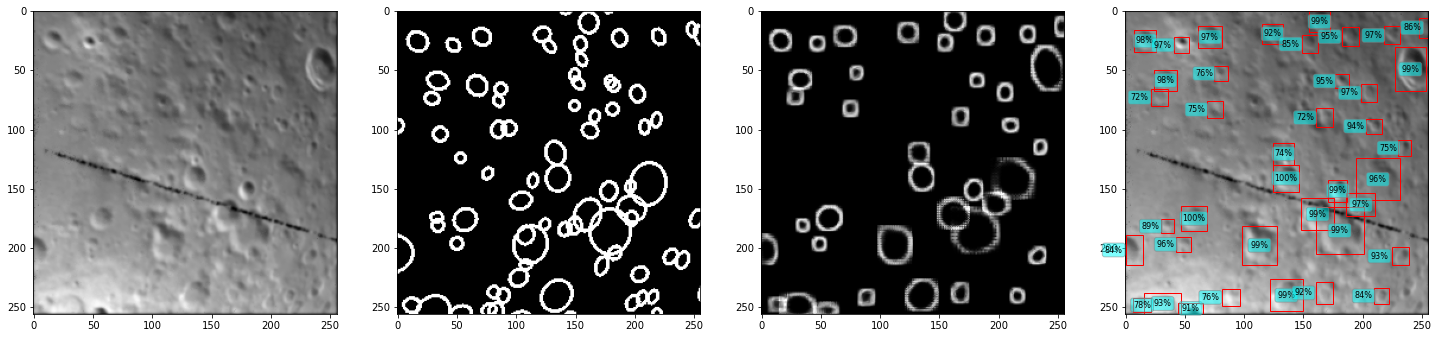

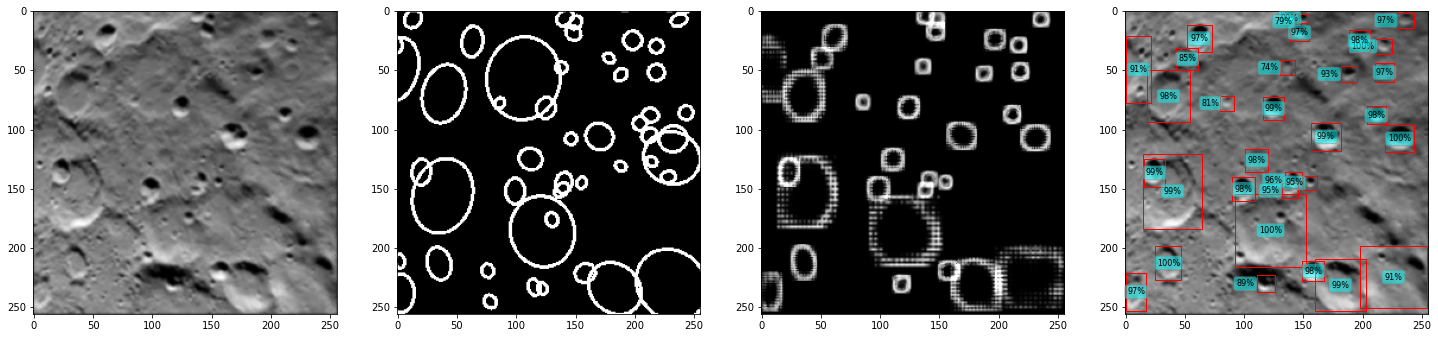

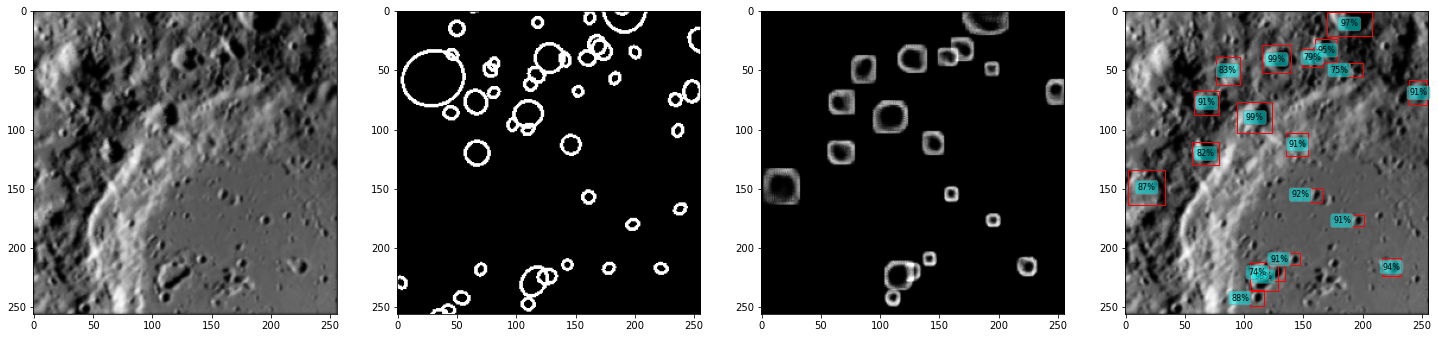

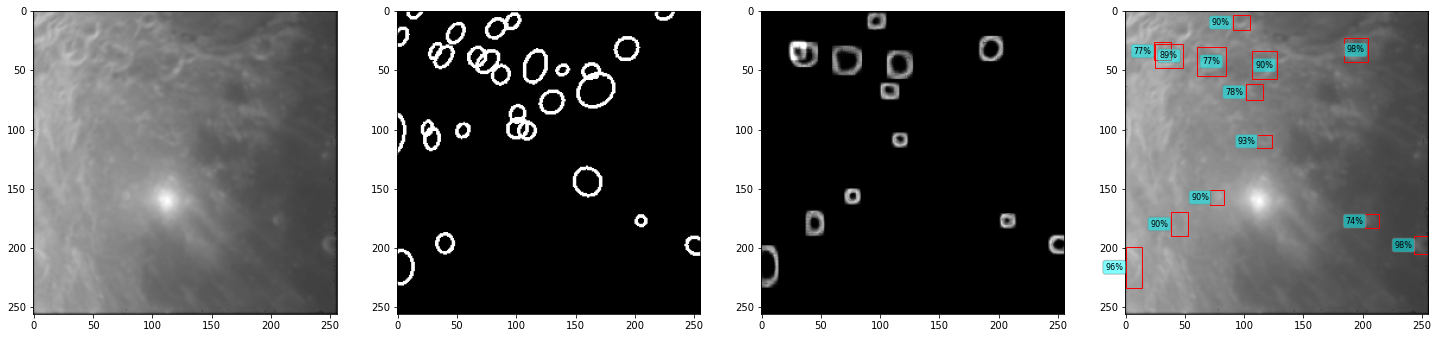

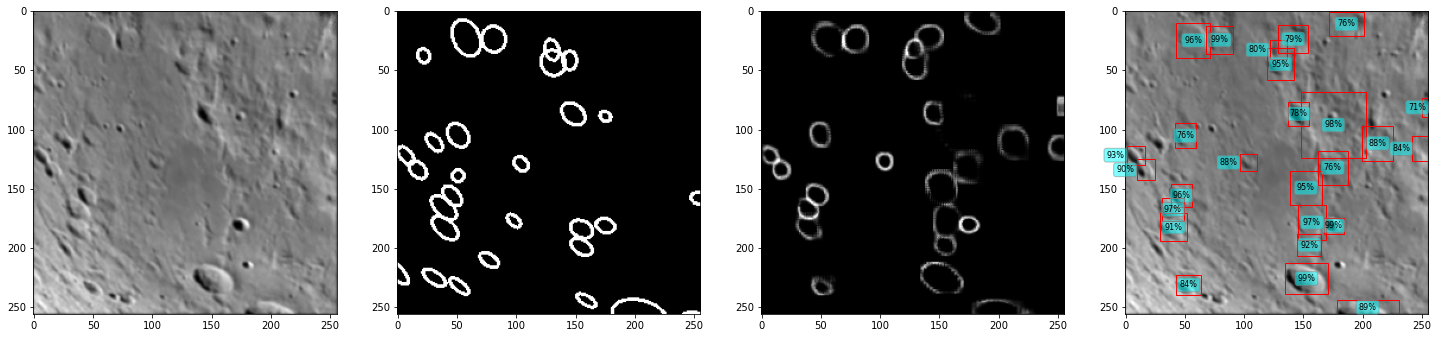

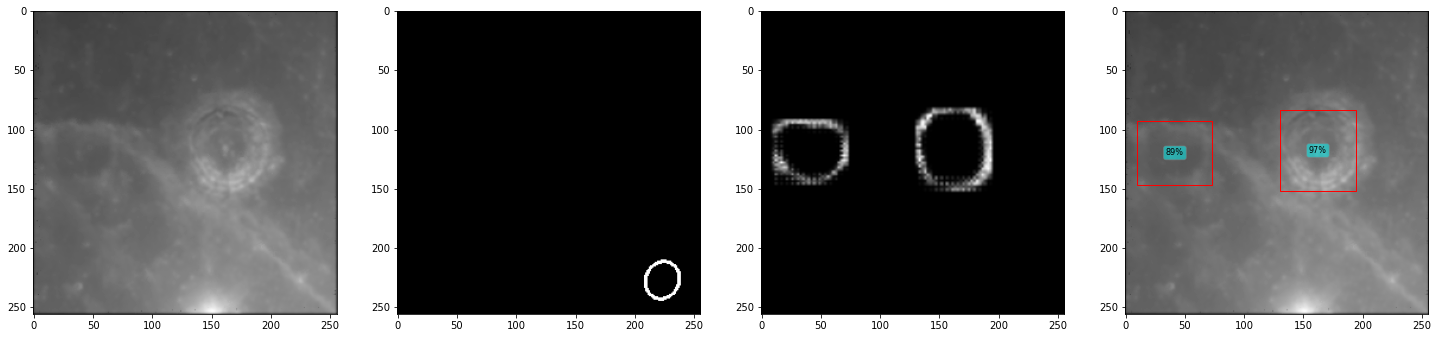

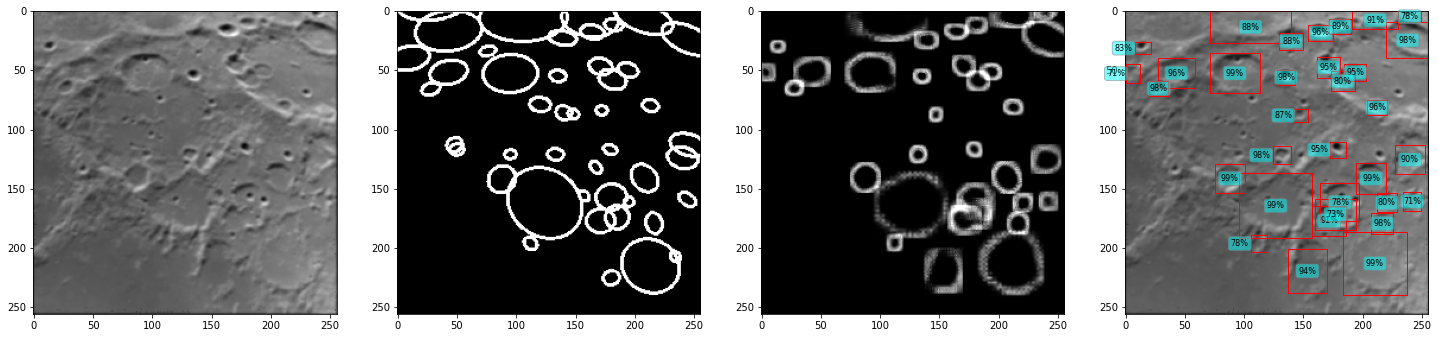

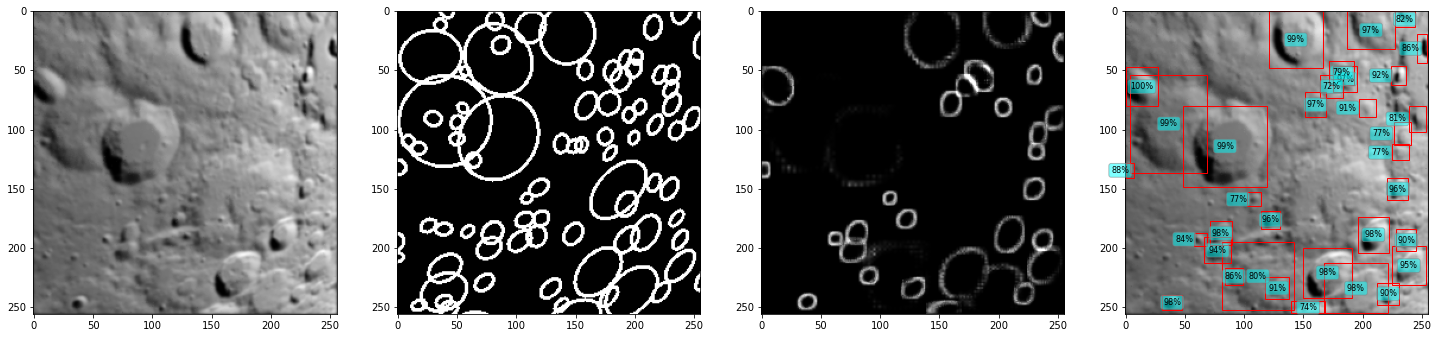

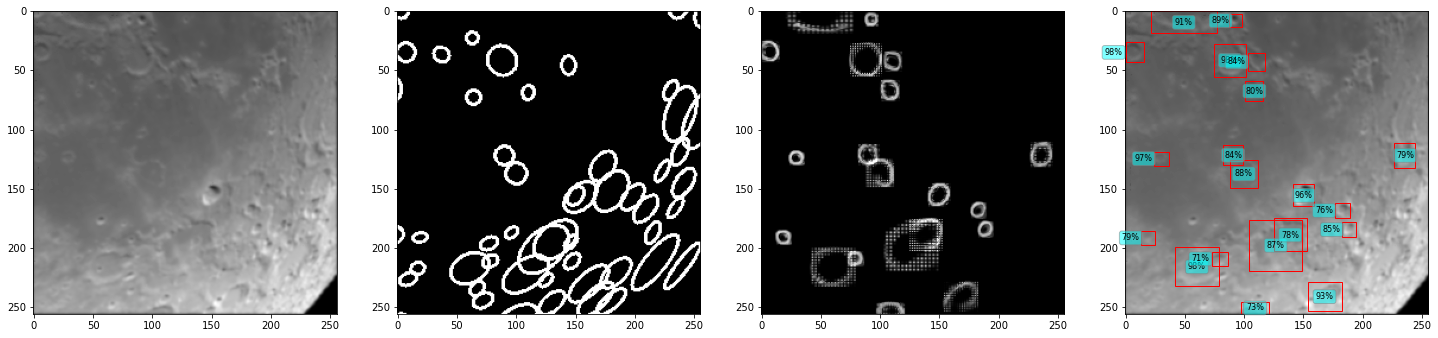

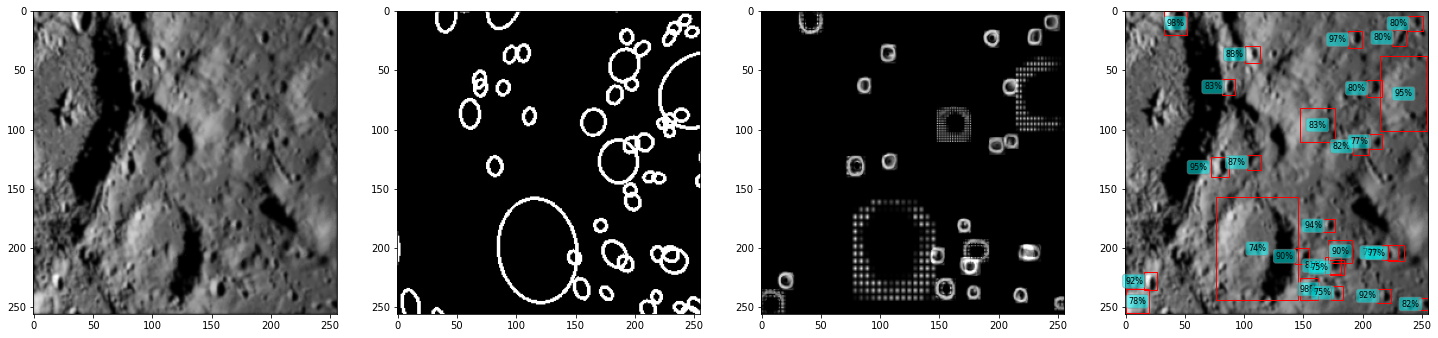

In [6]:
num_epochs = 17

tracked_params = ('momentum', 'weight_decay', 'dampening')

name = "Mask RCNN"
# name += " | Edge |" if "edge" in dataset_path else " | Filled |"
name += " | Pretrained" if pretrained else " | Cold Start"

run_args = dict(run_name=name)

if pretrained:
    start_e = checkpoint['epoch'] + 1
    run_id = checkpoint['run_id']
    run_metrics = checkpoint['run_metrics']
    run_args['run_id'] = run_id
else:
    start_e = 1
    run_metrics = dict(
        train=dict(
            batch=list(),
            loss_total=list(),
            loss_classifier=list(),
            loss_box_reg=list(),
            loss_mask=list(),
            loss_objectness=list(),
            loss_rpn_box_reg=list()
        ),
        valid=dict(
            batch=list(),
            loss_total=list(),
            loss_classifier=list(),
            loss_box_reg=list(),
            loss_mask=list(),
            loss_objectness=list(),
            loss_rpn_box_reg=list()
        )
    )

with mlflow.start_run(**run_args) as run:
    run_id = run.info.run_id
    print(run_id)

    if pretrained:
        mlflow.log_param('checkpoint_file', os.path.basename(checkpoint_path))

    if not pretrained:
        mlflow.log_param('optimizer', type(optimizer).__name__)
        mlflow.log_param('dataset', os.path.basename(dataset_path))
        for tp in tracked_params:
            try:
                mlflow.log_param(tp, optimizer.state_dict()['param_groups'][0][tp])
            except KeyError as err:
                pass

    for e in range(start_e, num_epochs+start_e):
        print(f'\n-----Epoch {e} started-----\n')

        since = time.time()

        mlflow.log_metric('lr', optimizer.state_dict()['param_groups'][0]['lr'], step=e)

        model.train()
        bar = tq(train_loader, desc=f"Training [{e}]",
                 postfix={
                     "loss_total": 0.,
                     "loss_classifier": 0.,
                     "loss_box_reg": 0.,
                     "loss_mask": 0.,
                     "loss_objectness": 0.,
                     "loss_rpn_box_reg": 0
                 })
        for batch, (images, targets) in enumerate(bar, 1):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with autocast():
                loss_dict = model(images, targets)

            loss = sum(l for l in loss_dict.values())

            if not math.isfinite(loss):
                del images, targets
                raise RuntimeError(f"Loss is {loss}, stopping training")

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            postfix = dict(loss_total=loss.item())
            run_metrics["train"]["loss_total"].append(loss.item())
            run_metrics["train"]["batch"].append(batch)

            for k, v in loss_dict.items():
                postfix[k] = v.item()
                run_metrics["train"][k].append(v.item())

            bar.set_postfix(ordered_dict=postfix)

        for k, v in run_metrics["train"].items():
            if k == "batch": continue
            mlflow.log_metric("train_"+k, mean(v[(e-1)*len(train_loader):e*len(train_loader)]), step=e)

        with torch.no_grad():
            bar = tq(validation_loader, desc=f"Validation [{e}]",
                     postfix={
                         "loss_total": 0.,
                         "loss_classifier": 0.,
                         "loss_box_reg": 0.,
                         "loss_mask": 0.,
                         "loss_objectness": 0.,
                         "loss_rpn_box_reg": 0
                     })
            for batch, (images, targets) in enumerate(bar, 1):
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                with autocast():
                    loss_dict = model(images, targets)

                loss = sum(l for l in loss_dict.values())

                if not math.isfinite(loss):
                    del images, targets
                    raise RuntimeError(f"Loss is {loss}, stopping validation")

                postfix = dict(loss_total=loss.item())
                run_metrics["valid"]["loss_total"].append(loss.item())
                run_metrics["valid"]["batch"].append(batch)

                for k, v in loss_dict.items():
                    postfix[k] = v.item()
                    run_metrics["valid"][k].append(v.item())

                bar.set_postfix(ordered_dict=postfix)

        for k, v in run_metrics["valid"].items():
            if k == "batch": continue
            mlflow.log_metric("valid_"+k, mean(v[(e-1)*len(validation_loader):e*len(validation_loader)]), step=e)

        time_elapsed = time.time() - since
        scheduler.step()

        checkpoint_path = f"../blobs/CraterRCNN_{run_id}.pth"

        state_dict = {
            'epoch': e,
            'run_id': run_id,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'run_metrics': run_metrics
        }

        torch.save(
            state_dict,
            checkpoint_path
        )

        mlflow.pytorch.log_state_dict(state_dict, artifact_path="checkpoint")

        model.eval()
        with torch.no_grad():
            images, targets = next(iter(test_loader))
            images = list(image.cuda() for image in images)
            targets = [{k: v.cuda() for k, v in t.items()} for t in targets]

            out = model(images)

        min_score = 0.7

        boxes, labels, scores, masks = map(lambda x: x.cpu(), out[0].values())

        fig, axes = plt.subplots(1, 4, figsize=(25, 20))

        axes[0].imshow(images[0][0].cpu().numpy(), cmap='gray')
        axes[1].imshow(torch.sum(targets[0]['masks'], dim=0).clamp(0, 1).cpu().numpy(), cmap='gray')
        axes[2].imshow(torch.sum(out[0]['masks'][scores > min_score], dim=0).clamp(0, 1).cpu().numpy()[0], cmap='gray')
        draw_patches(images[0].cpu(), boxes, labels, scores, masks, min_score=min_score, ax=axes[3])

        mlflow.log_figure(fig, f"sample_output_e{e}.png")

        print(
        f"\nSummary:\n",
        f"\tEpoch: {e}/{num_epochs+start_e}\n",
        f"\tAverage train loss: {mean(run_metrics['train']['loss_total'][(e-1)*len(train_loader):e*len(train_loader)])}\n",
        f"\tAverage validation loss: {mean(run_metrics['valid']['loss_total'][(e-1)*len(validation_loader):e*len(validation_loader)])}\n",
        f"\tDuration: {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s"
        )
        print(f'-----Epoch {e} finished.-----\n')

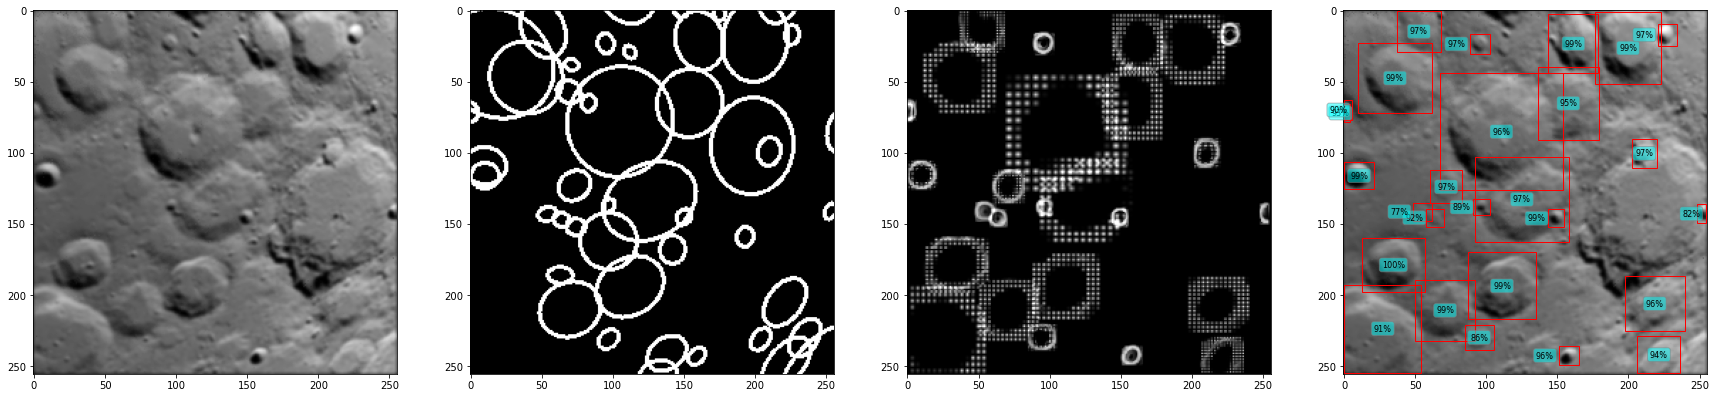

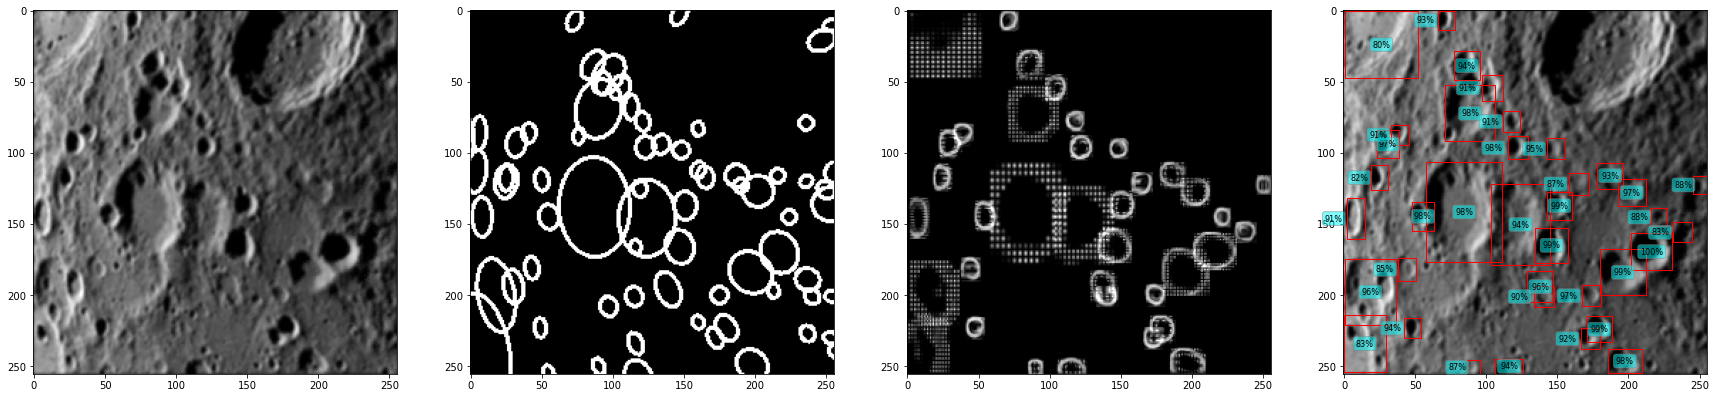

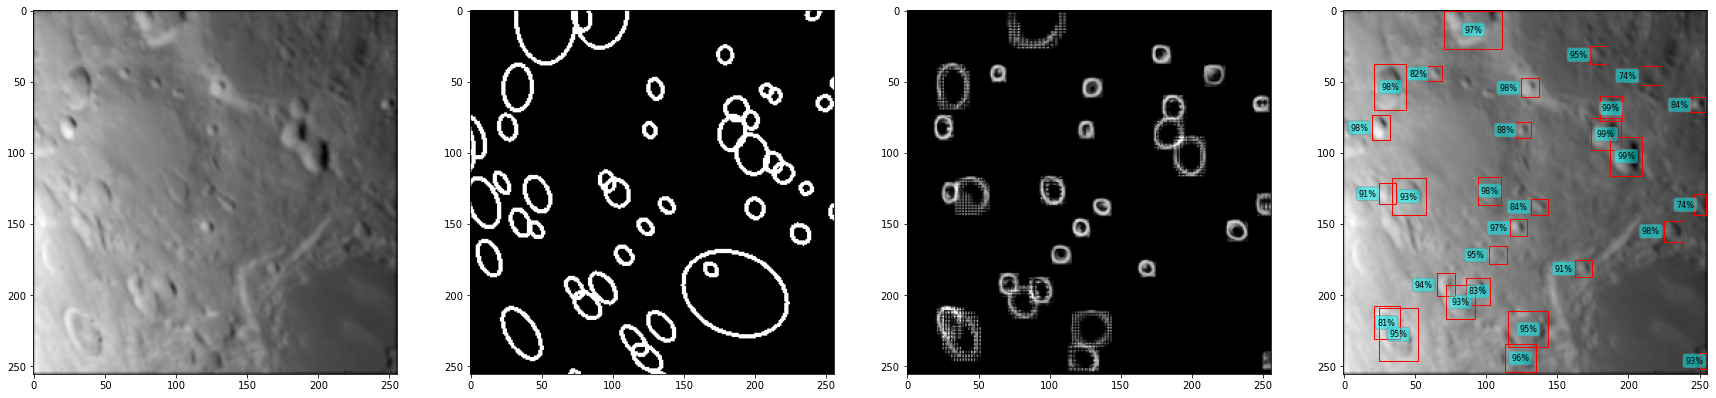

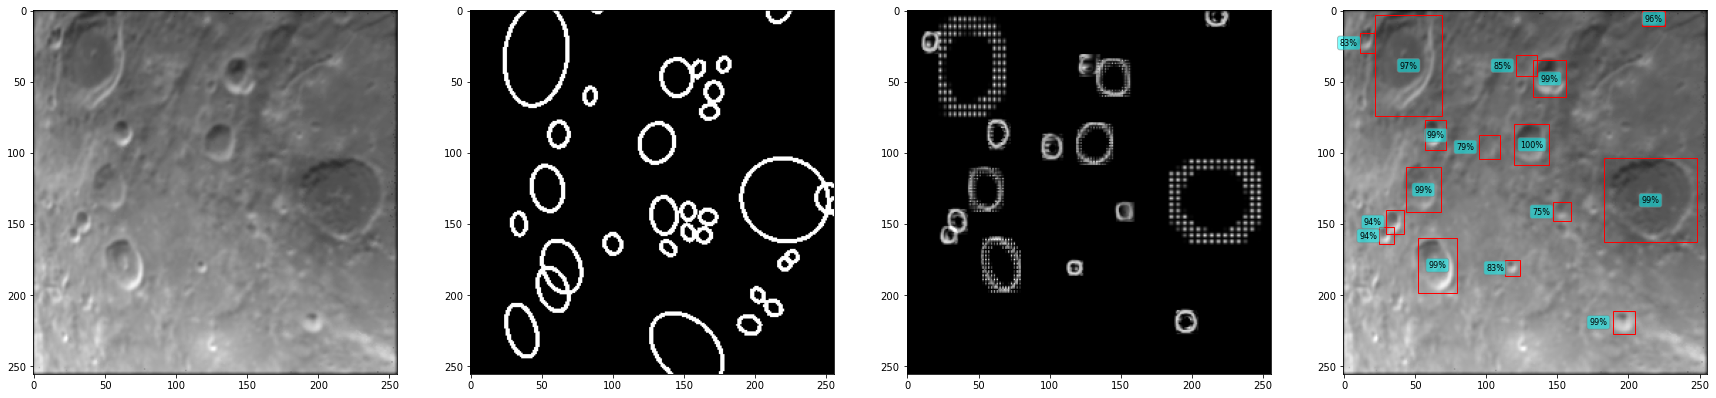

In [7]:
model.eval()
with torch.no_grad():
    images, targets = next(iter(test_loader))
    images = list(image.cuda() for image in images)
    targets = [{k: v.cuda() for k, v in t.items()} for t in targets]

    out = model(images)

min_score = 0.7

for i in range(test_loader.batch_size):
    boxes, labels, scores, masks = map(lambda x: x.cpu(), out[i].values())

    fig, axes = plt.subplots(1, 4, figsize=(30, 40))

    axes[0].imshow(images[i][0].cpu().numpy(), cmap='gray')
    axes[1].imshow(torch.sum(targets[i]['masks'], dim=0).clamp(0, 1).cpu().numpy(), cmap='gray')
    axes[2].imshow(torch.sum(out[i]['masks'][scores > min_score], dim=0).clamp(0, 1).cpu().numpy()[0], cmap='gray')
    draw_patches(images[i].cpu(), boxes, labels, scores, min_score=min_score, ax=axes[3])